In [8]:
from datetime import datetime, timedelta
from scipy.interpolate import make_interp_spline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import xlwt

### C308 问题报告

#### 竞赛的题目如下：

大多数乘客下飞机后要去市区(或周边)的目的地，出租车是众多旅客离开机场的 首选交通工具。国内多数机场都是将出发与到达通道分开的。送客到机场的出租车司机 都将会面临两个选择:

(A) 前往到达区排队等待载客返回市区。出租车必须到指定的“蓄车池”排队等候，依 “先来后到”排队进场载客，等待时间长短取决于排队出租车和乘客的数量多少，需要付 出一定的时间成本。

(B) 直接放空返回市区拉客。出租车司机会付出空载费用和可能损失潜在的载客收 益。

在某时间段抵达的航班数量和“蓄车池”里已有的车辆数是司机可观测到的确定信 息。通常司机的决策与其个人的经验判断有关。如果乘客在下飞机后想“打车”，就要到 指定的“乘车区”排队，按先后顺序乘车。在实际中，还有很多影响出租车司机决策的确 定和不确定因素，其关联关系各异，影响效果也不尽相同。

  现在需要建立数学模型解决下列问题:

(1) 分析与出租车司机决策相关因素的影响机理，建立出租车司机选择决策模型，给 出司机的选择策略。

(2) 收集国内某一机场及其所在城市出租车的相关数据，给出该机场出租车司机的 选择方案，并分析模型的合理性和对相关因素的依赖性。

(3) 经常会出现出租车排队载客和乘客排队乘车的情况。某机场“乘车区”现有两条 并行车道，管理部门应如何设置“上车点”，并合理安排出租车和乘客，在保证车辆和乘 客安全的条件下，使得总的乘车效率最高。

(4) 机场的出租车载客收益与载客的行驶里程有关。试给出一个可行的“优先”安排 方案, 使得这些出租车的收益尽量均衡。


自己的话：数学建模是对具体的问题做分析，本题是给机场解决出租车排队问题，并考虑司机的收益

分析问题可以明白一些方向：
- 数据需要自己去搜索
- 主要场景在机场
- 需要考虑司机收益，因此需要计算不同情况下利润
- 排队情况，则需要考虑时间和概率
- 出租车的拉客可能不止一人，不是每人都需要使用出租车
- 空车离开和载客离开的时间和收益不同

首先研读论文的摘要：本论文运用了 排队论中的生灭过程理论、添加数据噪声的分析方式、蒙特卡洛法。因此研读之前需要去了解以上的基本知识。

摘要也阐述了本论文团队的基本思路，和研究对象。由于没有作者的数据，因此需要去收集一些相关数据。

本文先分析问题，在分析问题中简单的表明了文章的思路流层图
![思路框图示意图](1631658303341_.pic.jpg)

为了流畅的写作，先剔除以下假设：
```
1. 不考虑不同车速下对每公里油耗的影响的差异，即每公里油耗为恒定值。 2. 单位时间内因器件损耗造成的其他成本视为恒定值。
3. 不计乘客因上不同车道上的车而造成的微小时间差。
4. 收集的求解需要的的数据真实准确可信。
```

解释了本文的符号
![符号说明](1641658303695_.pic.jpg)


复现论文时的数据（部分）如下：

| arrive | depart  |
|:------:|:-------:|
| 15:15  | 	09:35  |
| 18:00  | 	15:35  |
| 18:00  | 	15:35  |
| 18:00  | 	15:35  |
| 18:00  | 	15:35  |
| 20:05  | 	08:00  |
| 20:05  | 	08:00  |
| 22:50  | 	08:20  |
| 22:50  | 	09:00  |
| 22:50  | 	09:00  |
| 22:50  | 	09:00  |
| 09:20  | 	11:00  |
| 09:20	 |  11:00  |

arrive 一架飞机到达上海浦东的时刻

depart 一架飞机飞离上海浦东的时刻

## 问题一

文章先说明了影响决策的因素，再逐一给出相关因素的公式，最后将公式合并起来进行整体解释

### 时间构成
论文解释的时间构成：

A时间构成
![A时间构成](1661658306394_.pic.jpg)

B时间构成
![B时间构成](1671658306399_.pic.jpg)

### 收益构成

A选择下：

$\Delta E_A = \frac{E_A} {t_A}$

其中：$E_A = P_A - C_A$

时间: $t_A = t_c + t_w + t_{dA} = t_l + t_{dA}$, t_dA 为路程时间

而t_l需要生灭过程公式
![生灭公式](1651658305684_.pic.jpg)

其他量：$P_r(t)$ 计算易得

B选择下：

$\Delta E_B = \frac{E_B} {t_B}$

其中: $E_B = \sum\limits_{i=1}^n P_i - C_B$ , 

其中: $C_B = \Phi \sum\limits_{i=1}^n X_i + C$'

其中: $t_B = t_C + \sum\limits_{i=1} t_{dA} $


## 提供决策

用 $\Delta E_A$ 与 $\Delta E_B$ 的关系，有：
![决策](1681658306747_.pic.jpg)



生灭过程如下：
![生灭模型](1691658306924_.pic.jpg)

## 问题二

问题二在问题一的基础上把数据代入

按照论文写了如下代码：

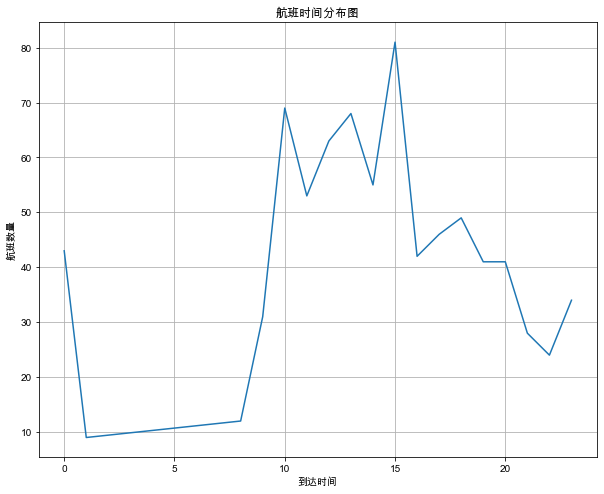

In [2]:
# 机场航班到达分布
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False      # 解决保存图像时 负号'-' 显示为方块和报错的问题。

data = pd.read_excel('airplanes.xls', sheet_name='airplane_arrive')

times = pd.to_datetime(data['arrive'])

arrive_statistics = pd.DataFrame(data.groupby(times.dt.floor('60Min')).size().reset_index())

def arrive(x):
    return int(x['arrive'].strftime('%H').__str__())


arrive_statistics.loc[:, "arrive"] = arrive_statistics.apply(arrive, axis=1)
# arrive_statistics.loc[17] = []

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(arrive_statistics['arrive'], arrive_statistics.loc[:, 0])

ax.grid()
ax.set_xlabel('到达时间')
ax.set_ylabel('航班数量')
ax.set_title("航班时间分布图")
plt.show()

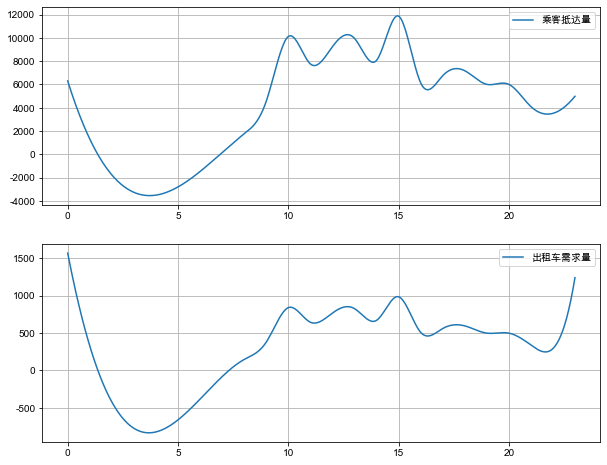

In [3]:
# 场乘客抵达量和出租车的需求量的函数图像
def smooth_xy(x_value: np.ndarray, y_value: np.ndarray):
    model = make_interp_spline(x_value, y_value)
    x_smooth = np.linspace(x_value.min(), x_value.max(), 500)
    y_smooth = model(x_smooth)
    return x_smooth, y_smooth


x_arrive = arrive_statistics['arrive']
AveNa = 146.65  # 每班平均载客量
AveNc = 1.81  # 出租车平均载客
Pa = arrive_statistics.loc[:, 0]  # 每小时到达架次
K = []  # 乘车比例
for i in x_arrive:
    if 1 >= 0 and i <= 5:
        K.append(0.45)
    elif i >= 23:
        K.append(0.45)
    else:
        K.append(0.15)

Pr = Pa * AveNa * np.array(K) / AveNc  # 出租车的需求量

x1, y1 = smooth_xy(x_arrive, Pa * AveNa)
x2, y2 = smooth_xy(x_arrive, Pr)

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(x1, y1)
ax1.legend(['乘客抵达量'])
ax2.plot(x2, y2)
ax2.legend(['出租车需求量'])
ax1.grid()
ax2.grid()
plt.show()

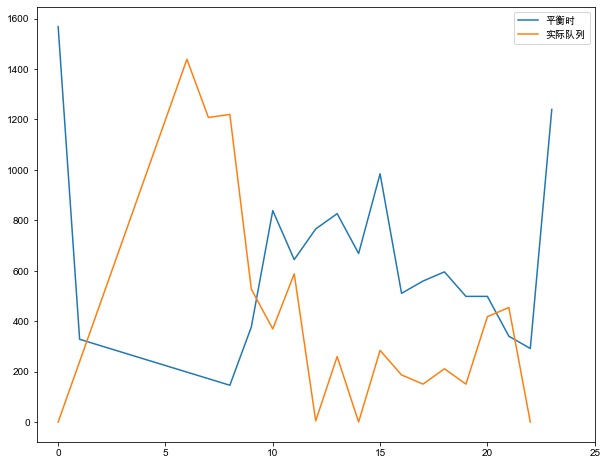

In [4]:
# 每个时刻下的和实际状况下出租车队列长度的函数图像
def depart(x):
    return int(x['depart'].strftime('%H').__str__())


times = pd.to_datetime(data['depart'])
depart_statistics = pd.DataFrame(data.groupby(times.dt.floor('60Min')).size().reset_index())
depart_statistics.loc[:, "depart"] = depart_statistics.apply(depart, axis=1)
# depart_statistics.loc[17] = [23, 0]
depart_statistics = pd.concat([pd.DataFrame({'depart': [0], 0: [0]}), depart_statistics], ignore_index=True)

Pa = depart_statistics.loc[:, 0]

x_depart = depart_statistics['depart']
Np = Pa * AveNa * np.array(K) / AveNc - Pr + 600
fig2, ax = plt.subplots(figsize=(10, 8))
Np_1 = [x if x > 0 else 0 for x in Np]

ax.set_xlim(-1, 25)

ax.plot(x_arrive, Pr)
ax.plot(x_depart, Np_1)
ax.legend(['平衡时', '实际队列'])

plt.show()

之后是通过对改变提到的相关因素的依赖性，观察B选择下的时长改变

![例1](1701658308084_.pic.jpg)

分析问题一的合理性

用高斯噪声处理，一般用于图像和声音。查阅资料理解目的是使得航班到达量契合高斯分布

代码如下：

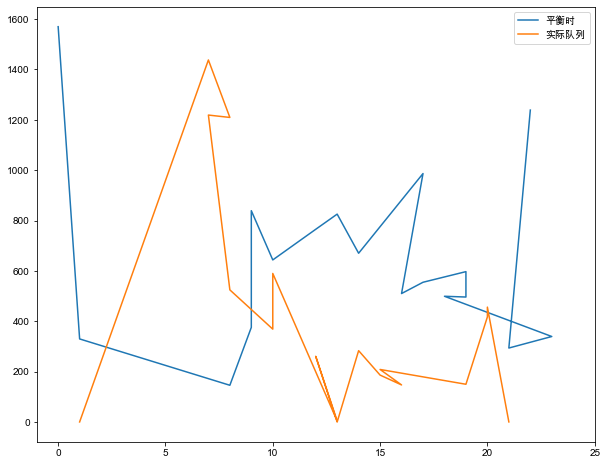

In [7]:
def gauss_noisy(x, y, sigma):
    """
    对输入数据加入高斯噪声
    :param x: x轴数据
    :param y: y轴数据
    :param sigma: 方差
    :return:
    """
    mu = 0
    for i in range(len(x)):
        # x[i] += random.gauss(mu, sigma)
        y[i] += random.gauss(mu, sigma)


fig3, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(-1, 25)

gauss_noisy(x_arrive, Pr, 1)
gauss_noisy(x_depart, Np_1, 1)
ax.plot(x_arrive, Pr)
ax.plot(x_depart, Np_1)
ax.legend(['平衡时', '实际队列'])

plt.show()

## 问题三
问题： 在某些时候，经常会出现出租车排队载客和乘客排队乘车的情况。某机场“乘车区”现有两条并行车道，管理部门应如何设置“上车点”，并合理安排出租车和乘客，在保证车辆和乘客安全的条件下，使得总的乘车效率最高。

通常的出租车进出站设计, 由题意选择b方式，两车道的情况。在这种情况下，变量为每次允许n量车进入上次点。

![进出站设计](1711658314003_.pic.jpg)

论文中，把乘客上车看作泊松分布，单车在t时间内上车概率为 $p=1-e^{-\lambda t}$则所有车在t时间内上车的概率为$P_n = p^n$

为使乘车效率最大，即使 $s.t.max(n/t_{per})$ 最大

$t_{per}$：一轮出租车中第一辆车从进入上客区开始到最后一辆车驶离上客区的时间

$t_{per} = nE + t_{in} + t_{out} = n^2\int^{\infty}_{\infty} \lambda e^{-\lambda} (1-e^{-\lambda})dt + \frac {k}{2}
[\frac {nl}{v} + (n-1)t_r]$

E: 上车区的所有出租车从进入上客区到发车离开时花费的平均时间

$t_{in}$ = $t_{in}$:动态的可以视为进入与离去为平衡，则时间相同

有如下代码：

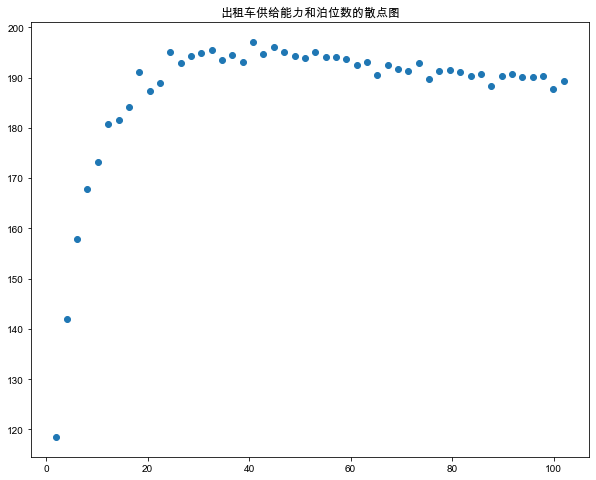

In [15]:
def myfun(x):
    k = 2 # 上客区的车道数量
    t = []
    for _ in range(1500):  # 蒙特卡洛次数
        ar = []
        for _ in range(x):  # 不一定满车，取不同数量计算
            mu=(30 + x * 2.5)  # 参数为lamda的指数分布
            ar.append(np.random.exponential(mu))  # 所有出租车从到上客区熄火到发车离开的时间, 指数分布随机变量
        r = max(ar) # 取ar的最大值表示最差的情况（时间最多）
        t.append(r + 2 * (x * 5 / (5/3.6) + 1 * (x-1)) / k)
    return 1500 * x / sum(t)


f = [] # 所假设的泊位数的个数,从2到100，步长=2
for i in range(2,102,2):
    f.append(myfun(i)) # 第j个泊位对应的供给能力
x = np.linspace(2, 102, 50) # 泊位数为偶数
f = 3600 * np.array(f) # 3600 * 出租车供给能力（辆/s）= 出租车供给能力（辆/h）

fig4, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, f)
ax.set_title('出租车供给能力和泊位数的散点图')
plt.show()

workbook = xlwt.Workbook(encoding='utf-8')
worksheet = workbook.add_sheet('three_data')
for i, d in enumerate(f):
    worksheet.write(i, 0, d)
workbook.save('three_data.xls'.__str__())

车数量最大值的 0.9 倍进行搜寻得到此时的乘车点数。在保证车辆和乘客安全的条件下，为使总的乘车效率最高，共设置 5 个乘车点共 10 个泊车位，


## 问题四
描述：机场的出租车载客收益与载客的行驶里程有关。试给出一个可行的“优先”安排 方案, 使得这些出租车的收益尽量均衡。

论文是在 收益和时间相同 情况下计算出短途车优先插队。可以发现问题四在问题二的基础上增加参数$\gamma$来表示短途与长途的比例

得出图像
![收益](1721658389325_.pic.jpg)

得出结论：$\gamma$越短，短途车🈷️靠近前方插队。也符合生活直觉，距离越短收益越少。

之后就是模型检验，方式和问题一相似

与C137类似，数学建模的基本写作为：先分析问题再讲思路流程最后解答问题

在语言描述问题的解答过程时，穿插使用数学模型并解释数学模型的参数和意义，有利于文章的层次感